# Race Data Analysis

Goal of this notebook is to get some insight into some Race Data. Its from four different race tracks of different drivers splitted into 42 xml files with a total of 283mB. The Data itself is confidential, so only small snippets of the raw data will be shown.

## 1.) Data Gathering

From the Folderstructure we know there are four different tracks each with a different number of races. One Race per File.
Each file contains Trackpoints for several laps. The first lap of each track is a warmup round without actual data. Per Trackpoint the following data is provided: 

* GPS coordinates
* Heading
* Distance driven
* altitude above sea level
* several sensor data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import operator
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import copy
from scipy.signal import argrelextrema
from collections import deque
import seaborn as sns
import math
from scipy.signal import find_peaks

Form Panda Dataframe from given XML files


In [2]:
import glob
import xml.etree.ElementTree as ET
namespace = "{http://www.topografix.com/GPX/1/1}"
root_dir = './GPX Files\\'

#data should look like this, so it can be converted to pandas dataframe:
data = []
#dict to store race info like circuitname lap etc.
raceinfo = {"circuitname": "", "racenumber": -1, "lapCounter":0, "tracklength": 0}
for filename in glob.iglob(root_dir + '**/*.gpx', recursive=True):
    
    #if FileName is Track: Skip
    if 'Track' in str(filename):
        continue
        
    print ('currentFile', filename)
    
    currentcircuitname = filename.split(root_dir)[1].split("\\")[0]
    #racefilename = filename.split(root_dir)[1].split("\\")[1]

    # reset racenumber on new type of circuit
    if currentcircuitname != raceinfo["circuitname"]:
        raceinfo["racenumber"] = 1
        raceinfo["circuitname"] = currentcircuitname
                
    # reset laps
    raceinfo["lapCounter"] = 0
        
    root = ET.parse(filename).getroot()
    
    #RaceDriver Id and Name
    raceMeta = root.find (namespace + "metadata").find(namespace + "extensions").find(namespace + "raceMeta")
    userProfileName = None
    userProfileGUID = None
    for amgraw in raceMeta.findall("*"):
        amg = str(amgraw).split("{https://www.mercedes-amg.com/xsd/gpx-ext}")[1].split('\'')[0]
        if amg == "userProfileName":
            userProfileName = str(amgraw.text)
        elif amg == "userProfileGUID":
            userProfileGUID = str(amgraw.text)
            
    #track length
    trackmeta = root.find (namespace + "metadata").find(namespace + "extensions").find(namespace + "trackMeta")
    for amgraw in trackmeta.findall("*"):
        amg = str(amgraw).split("{https://www.mercedes-amg.com/xsd/gpx-ext}")[1].split('\'')[0]
        if amg == "length":
            raceinfo["tracklength"] = str(amgraw.text)
        
    raceinfo["userProfileName"] = userProfileName
    raceinfo["userProfileGUID"] = userProfileGUID
        
    for lap in root.findall(namespace + "trk"):
        #first <trk>(=fist lap) is only general trackdata and is not needed
        if raceinfo["lapCounter"] > 0:
            #get AverageLapSpeed in kmh and Top Speed  in kmh + Laptime in ms
            averageLapSpeed = float(lap.find(namespace + "extensions").find(namespace + "lapAverageSpeed").text)/10
            topLapSpeed = float(lap.find(namespace + "extensions").find(namespace + "lapTopSpeed").text)/10
            lapTime = float(lap.find(namespace + "extensions").find(namespace + "lapTime").text)/1000
            
            raceinfo["segCounter"] = 1
            for seg in lap.findall(namespace +"trkseg"):
                for trkpt in seg.findall(namespace + "trkpt"):
                    #add race data
                    current_trkpt_data = copy.deepcopy(raceinfo)
                    #add lap data
                    current_trkpt_data["averageLapSpeed"] = averageLapSpeed
                    current_trkpt_data["topLapSpeed"] = topLapSpeed
                    current_trkpt_data["lapTime"] = lapTime
                    #copy trackpoint attributes
                    current_trkpt_data.update(trkpt.attrib)
                    #copy tags of trackpint
                    for tag in trkpt.find(namespace + "extensions").findall("*"):
                        key = str(tag).split(namespace)[1].split("'")[0]
                        value = tag.text
                        current_trkpt_data[key] = value
                    #add to data
                    data.append(copy.deepcopy(current_trkpt_data))
                raceinfo["segCounter"]+=1
        raceinfo["lapCounter"]+=1
    raceinfo["racenumber"]+=1
    print("total datapoints: " + str(len(data)))


currentFile ./GPX Files\Circuit Ricardo Tormo unofficial\Race_20171204T093133.gpx
total datapoints: 5638
currentFile ./GPX Files\Circuit Ricardo Tormo unofficial\Race_20171205T074157.gpx
total datapoints: 33191
currentFile ./GPX Files\Circuit Ricardo Tormo unofficial\Race_20171205T110519.gpx
total datapoints: 58810
currentFile ./GPX Files\Circuit Ricardo Tormo unofficial\Race_20171205T131202.gpx
total datapoints: 84760
currentFile ./GPX Files\Circuit Ricardo Tormo unofficial\Race_20171207T130651.gpx
total datapoints: 108741
currentFile ./GPX Files\Circuit Ricardo Tormo unofficial\Race_20171208T081031.gpx
total datapoints: 119775
currentFile ./GPX Files\Circuit Ricardo Tormo unofficial\Race_20171209T125620.gpx
total datapoints: 132088
currentFile ./GPX Files\Circuit Ricardo Tormo unofficial\Race_20171209T144140.gpx
total datapoints: 135814
currentFile ./GPX Files\Circuit Ricardo Tormo unofficial\Race_20171209T153538.gpx
total datapoints: 137882
currentFile ./GPX Files\Circuit Ricardo To

In [3]:
df = pd.DataFrame(data)

In [4]:
df.shape

(265357, 142)

## 2.) Data Exploration: Lets get some overview

In [5]:
#number of races and segments per circuitname

In [6]:
df_overview_0 = df[['circuitname', 'racenumber', 'segCounter']].groupby('circuitname').max()
df_overview_0

,racenumber,segCounter
circuitname,,
Circuit Ricardo Tormo unofficial,15,3
Circuito del Jarama,3,1
Idiada Handling,5,1
Sachsenring,15,3


In [7]:
#number of total laps per circuitname
df_lapcounter = df[['circuitname', 'racenumber','lapCounter']].groupby(['circuitname','racenumber']).max(['lapCounter']) \
.groupby('circuitname').sum()
df_overview_1 = df_overview_0.copy()
df_overview_1["total laps"] = df_lapcounter
df_overview_1

,racenumber,segCounter,total laps
circuitname,,,
Circuit Ricardo Tormo unofficial,15,3,91
Circuito del Jarama,3,1,5
Idiada Handling,5,1,25
Sachsenring,15,3,43


In [8]:
#number of total trackpoints per circuitname
df_total_trackpoints = df['circuitname'].value_counts().to_frame('trackpoints')
df_overview_2 = df_overview_1.copy()
df_overview_2["total_trackpoints"] = df_total_trackpoints
df_overview_2

,racenumber,segCounter,total laps,total_trackpoints
circuitname,,,,
Circuit Ricardo Tormo unofficial,15,3,91,191087
Circuito del Jarama,3,1,5,6091
Idiada Handling,5,1,25,17270
Sachsenring,15,3,43,50909


In [9]:
#mean number of trackpoints per lap
df_mean_number_of_trackpoints_per_lap= df[['circuitname', 'racenumber','lapCounter']].\
groupby(['circuitname','racenumber','lapCounter']).size().groupby("circuitname").mean().to_frame("mean trackpoint/lap")
df_mean_number_of_trackpoints_per_lap = df_mean_number_of_trackpoints_per_lap.reset_index()

df_overview_3 = df_overview_2.copy()
df_overview_3["mean trackpoint/lap"] = list(df_mean_number_of_trackpoints_per_lap["mean trackpoint/lap"])
df_overview_3


,racenumber,segCounter,total laps,total_trackpoints,mean trackpoint/lap
circuitname,,,,,
Circuit Ricardo Tormo unofficial,15,3,91,191087,2099.857143
Circuito del Jarama,3,1,5,6091,1218.200000
Idiada Handling,5,1,25,17270,690.800000
Sachsenring,15,3,43,50909,1183.930233


In [10]:
#circuit lenght and mean meters/ trackpoint
df_length = df[['circuitname','tracklength']].groupby(['circuitname','tracklength']).max()[:4]
df_length=df_length.reset_index()
df_overview_4 = df_overview_3.copy()
df_overview_4["tracklength"] = list(df_length["tracklength"])
df_overview_4["tracklength"] = df_overview_4["tracklength"].astype(float, errors = 'raise')
df_overview_4

,racenumber,segCounter,total laps,total_trackpoints,mean trackpoint/lap,tracklength
circuitname,,,,,,
Circuit Ricardo Tormo unofficial,15,3,91,191087,2099.857143,3959.47
Circuito del Jarama,3,1,5,6091,1218.200000,3850.37
Idiada Handling,5,1,25,17270,690.800000,2148.52
Sachsenring,15,3,43,50909,1183.930233,3572.85


In [11]:
df_overview_4['mean meter per trackpoint'] = df_overview_4['tracklength'] / df_overview_4["mean trackpoint/lap"]
df_overview_4

,racenumber,segCounter,total laps,total_trackpoints,mean trackpoint/lap,tracklength,mean meter per trackpoint
circuitname,,,,,,,
Circuit Ricardo Tormo unofficial,15,3,91,191087,2099.857143,3959.47,1.885590
Circuito del Jarama,3,1,5,6091,1218.200000,3850.37,3.160704
Idiada Handling,5,1,25,17270,690.800000,2148.52,3.110191
Sachsenring,15,3,43,50909,1183.930233,3572.85,3.017788


### 2.1) Lap-times

Lets find out about the laptimes per Lap per circuit.

<AxesSubplot:title={'center':'Lap times for Circuit Ricardo Tormo unofficial'}>

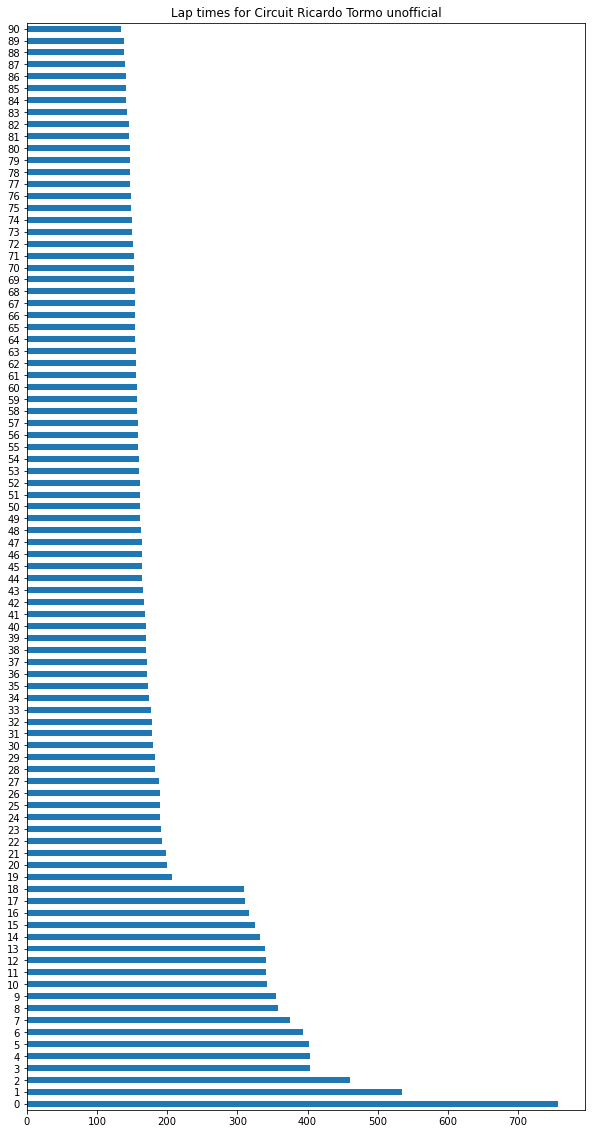

In [12]:
df_laptimes = df[["circuitname","racenumber","lapCounter", "lapTime"]].groupby(["circuitname","racenumber","lapCounter"]).max()
df_laptimes=df_laptimes.reset_index()

df_laptime_1 =df_laptimes.loc[df_laptimes['circuitname'] == "Circuit Ricardo Tormo unofficial"].sort_values("lapTime")
df_laptime_1 = df_laptime_1[::-1]
df_laptime_1.reset_index()["lapTime"].\
plot.barh( x="lapTime",y="index",figsize=(10,20), title = "Lap times for Circuit Ricardo Tormo unofficial")

<AxesSubplot:title={'center':'Lap times for Circuito del Jarama'}>

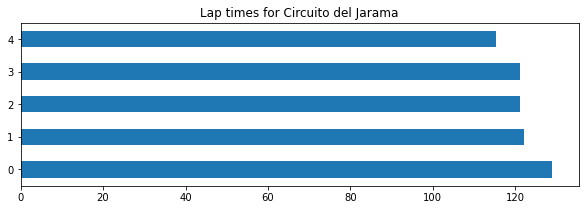

In [13]:
df_laptime_2 =df_laptimes.loc[df_laptimes['circuitname'] == "Circuito del Jarama"].sort_values("lapTime")
df_laptime_2 = df_laptime_2[::-1]
df_laptime_2.reset_index()["lapTime"].\
plot.barh( x="lapTime",y="index",figsize=(10,3), title = "Lap times for Circuito del Jarama")

<AxesSubplot:title={'center':'Lap times for Idiada Handling'}>

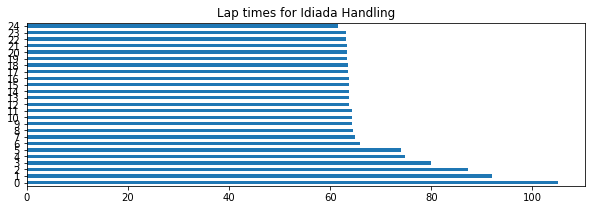

In [14]:
df_laptime_3 =df_laptimes.loc[df_laptimes['circuitname'] == "Idiada Handling"].sort_values("lapTime")
df_laptime_3 = df_laptime_3[::-1]
df_laptime_3.reset_index()["lapTime"].\
plot.barh( x="lapTime",y="index",figsize=(10,3), title = "Lap times for Idiada Handling")

<AxesSubplot:title={'center':'Lap times for Sachsenring'}>

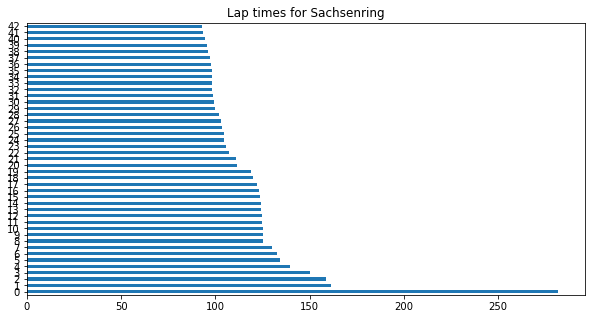

In [15]:
df_laptime_4 =df_laptimes.loc[df_laptimes['circuitname'] == "Sachsenring"].sort_values("lapTime")
df_laptime_4 = df_laptime_4[::-1]
df_laptime_4.reset_index()["lapTime"].\
plot.barh( x="lapTime",y="index",figsize=(10,5), title = "Lap times for Sachsenring")

### 2.2 Data Consistency

Some measurements are given for every Trackpoint some are only given for some Trackpoints. Lets get an intel.

<AxesSubplot:>

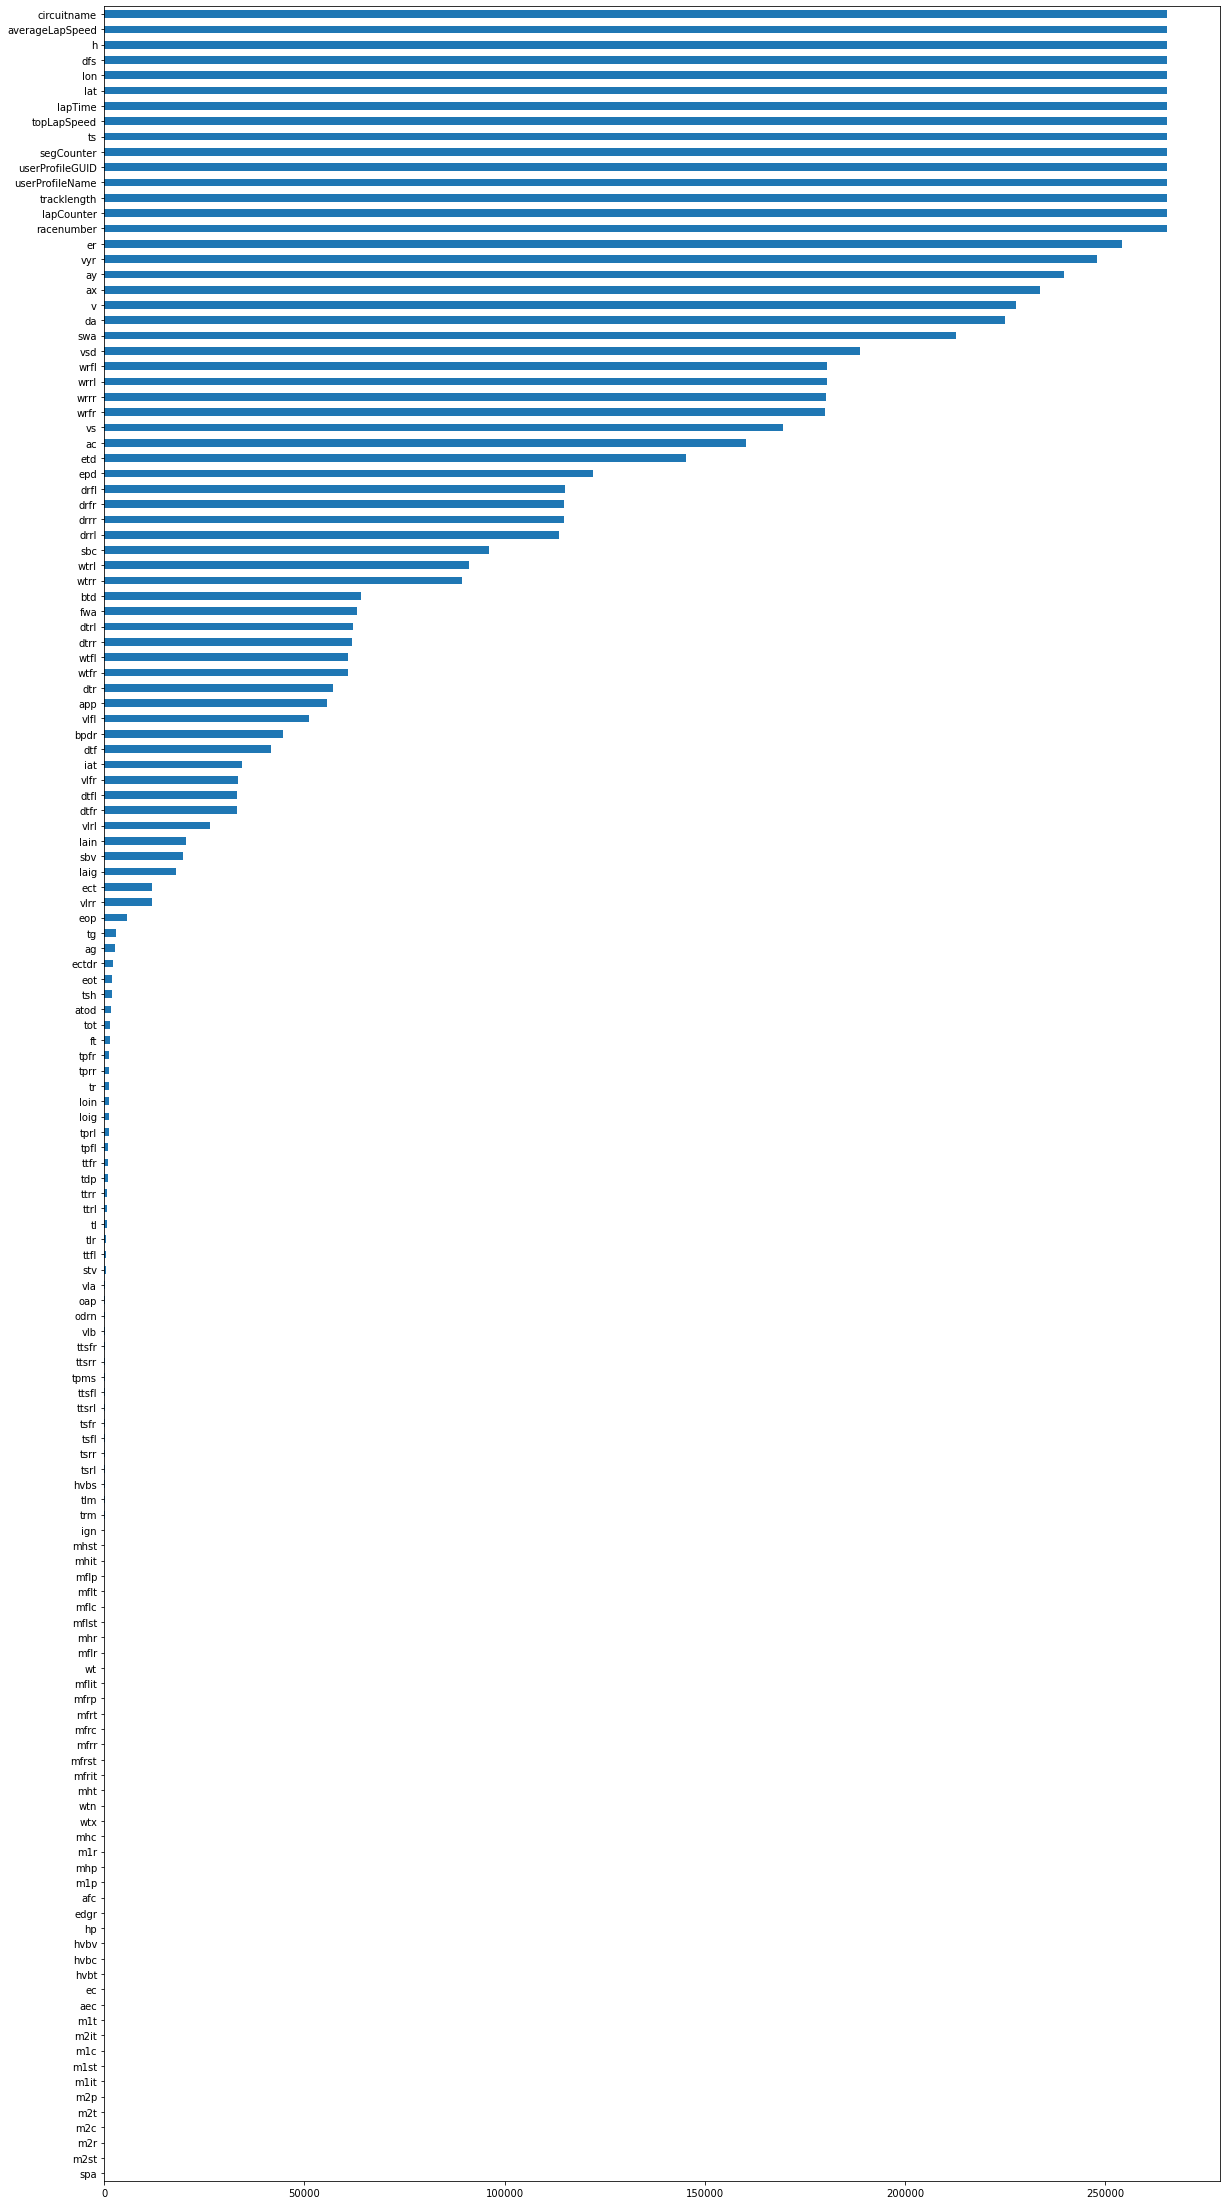

In [16]:
df_isnot_null = df.count()
df_isnot_null = df_isnot_null.sort_values()
df_isnot_null.plot.barh(x=1, y=0, figsize=(20,40))

In [17]:
(df_isnot_null == df_isnot_null.max()).sum()

15

15 Measurements are given for every Trackpoint. 127 are not given for every Trackpoint.

As we can see much data is not recorded for every Trackpoint. Lets check following important data:
- latitude
- longitude
- gear
- distance since start
- heading direction
- speed
- throttle
- braking torque
- steering angle

<AxesSubplot:ylabel='measurement'>

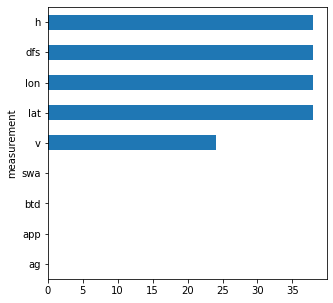

In [18]:
important_dataframe = df[['lat', 'lon', "ag", "dfs", "h", "v", "app", "btd", "swa", "circuitname", "racenumber"]] 
important_dataframe = important_dataframe.groupby(["circuitname", "racenumber"]).apply(lambda x: x.notnull().all())
del important_dataframe['racenumber']
del important_dataframe['circuitname']

important_dataframe_resettted =important_dataframe.reset_index(drop=True).sum().sort_values()
important_dataframe_resettted.plot.barh(figsize=(5,5),ylabel= "measurement")

heading, distance from start, longtitude, latitude are given for every trackpoint in all races. 

Speed is only complete for roughly 15 races.

Steering angle, braking torque, throttle and gear are not completely given for no race. 

### 2.3 Data Ranges

In [249]:
print("Distance from start has a range from " + str(df["dfs"].astype(float).min()) +\
      " to " + str(df["dfs"].astype(float).max()) + " metres.")
print("Heading has a range from " + str(df["h"].astype(float).min()) +\
      " to " + str(df["h"].astype(float).max()) + " degrees.")
print("Speed has a range from " + str(df["v"].astype(float).min()) + " to " + str(df["v"].astype(float).max())+ " metres per second.")
print("Gear has a range from " + str(df["ag"].astype(float).min()) + " to " + str(df["ag"].astype(float).max()))
print("Break Torque has a range from " + str(df["btd"].astype(float).min()) + " to " + str(df["btd"].astype(float).max())+ "Nm.")
print("steering wheel has a range from " + str(df["swa"].astype(float).min()/10) + " to " + str(df["swa"].astype(float).max()/10) + " degrees.")
print("Throttle has a range from " + str(df["app"].astype(float).min()) + " to " + str(df["app"].astype(float).max()))


Distance from start has a range from 0.0 to 3979.29 metres.
Heading has a range from 7.71935e-06 to 359.999 degrees.
Speed has a range from 0.0 to 80.7151 metres per second.
Gear has a range from 0.0 to 13.0
Break Torque has a range from 0.0 to 4890.0Nm.
steering wheel has a range from -353.2 to 409.2 degrees.
Throttle has a range from -128.0 to 250.0


## 3.)Analysis 

### 3.1 Correlations

In [20]:
corr_df =df[['lat', 'lon', "ag", "dfs", "h", "v", "app", "btd", "swa"]]
corr_df = corr_df.apply(pd.to_numeric)
#interpolate missing values liner manner-wise
corr_df=corr_df.interpolate()

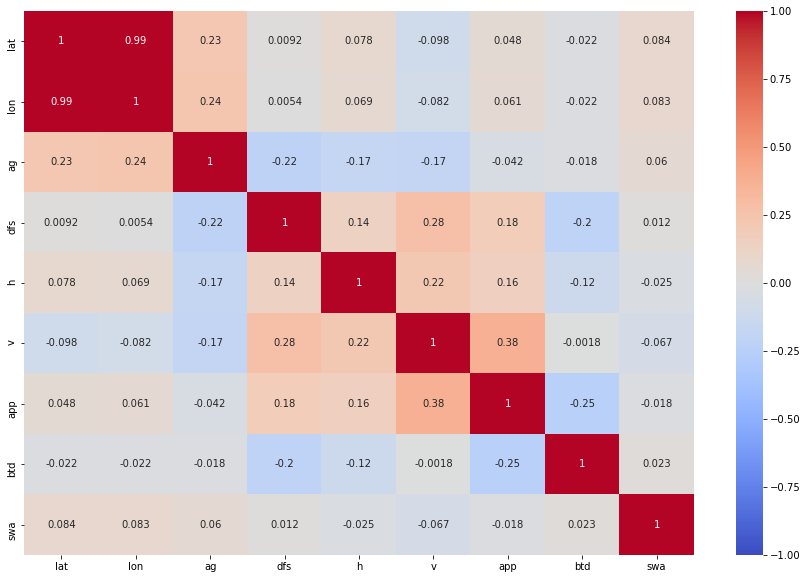

In [21]:
correlatedData = corr_df.corr()
plt.subplots(figsize=(30,20))
sns.heatmap(correlatedData, annot=True,cmap = 'coolwarm', vmin = -1)# ,vmin =-1, vmax=1

params = {
         'ytick.labelsize':'x-large'}

fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.rcParams.update(params)


For example velocity(v) correlates with throttle(app) highly positive (0.38).

### 3.2) For some tableau plots we want to use the following features:

- circuitname
- racenumber
- lap
- segment
- lapTime
- userProfileGUID
- userProfileName
- speed: v
- topLapSpeed
- averageLapSpeed
- total metres driven: dfs
- time-stamp: ts
- lat
- lon

In [22]:
tableau_dataframe = df[['circuitname','racenumber','lapCounter','segCounter','userProfileGUID','userProfileName','lapTime','v', \
                                  'topLapSpeed','averageLapSpeed','dfs', 'ts', 'lat', 'lon']] 

In [23]:
#write to File
tableau_dataframe.to_csv('secondTask_data.txt', sep=';', index=False)

lets see the tableau plots:

![Dashboard1-image](Dashboard1.png "Dashboard 1")

![Dashboard2-image](Dashboard2.png "Dashboard 2")

This can be explained by the fact that driving uphill costs energy. A greater influence is probably the height difference of the race track in comparison to how the curves are located.

![Dashboard3-image](Dashboard3.png "Dashboard 3")

## 3.3 Circuit seperation

Lets see if we can automatically detect:
- straight parts
- Curve entrances
- Center of curves
- Curve exit
- Braking points
- Throttle 100% after curve exit


Lets get the dataset of the first lap of Circuito del Jarama

In [206]:
circuit_seperation_df= df[['circuitname','racenumber','lapCounter','ts','lat','lon','swa','btd','app','userProfileName']] 
circuit_seperation_df = circuit_seperation_df[(circuit_seperation_df.circuitname == 'Circuito del Jarama')]
circuit_seperation_df = circuit_seperation_df[(circuit_seperation_df.racenumber == 1)]
circuit_seperation_df = circuit_seperation_df[(circuit_seperation_df.lapCounter ==1)]
circuit_seperation_df[['racenumber','lapCounter','ts','lat','lon','swa','btd','app']] =\
circuit_seperation_df[['racenumber','lapCounter','ts','lat','lon','swa','btd','app']].apply(pd.to_numeric, errors='coerce')
circuit_seperation_df = circuit_seperation_df.reset_index()
circuit_seperation_df.dtypes

index                int64
circuitname         object
racenumber           int64
lapCounter           int64
ts                   int64
lat                float64
lon                float64
swa                float64
btd                float64
app                float64
userProfileName     object
dtype: object

In [207]:
circuit_seperation_df

,index,circuitname,racenumber,lapCounter,ts,lat,lon,swa,btd,app,userProfileName
0,191087,Circuito del Jarama,1,1,0,40.614612,-3.583085,9.0,0.0,-6.0,Guest
1,191088,Circuito del Jarama,1,1,101,40.614612,-3.583085,15.0,NaN,NaN,Guest
2,191089,Circuito del Jarama,1,1,201,40.614596,-3.583078,16.0,NaN,NaN,Guest
3,191090,Circuito del Jarama,1,1,304,40.614487,-3.583032,NaN,NaN,NaN,Guest
4,191091,Circuito del Jarama,1,1,402,40.614433,-3.583009,NaN,NaN,NaN,Guest
...,...,...,...,...,...,...,...,...,...,...,...
1149,192236,Circuito del Jarama,1,1,114901,40.614833,-3.583167,9.0,NaN,NaN,Guest
1150,192237,Circuito del Jarama,1,1,115002,40.614779,-3.583144,10.0,NaN,NaN,Guest
1151,192238,Circuito del Jarama,1,1,115101,40.614731,-3.583124,NaN,NaN,75.0,Guest
1152,192239,Circuito del Jarama,1,1,115202,40.614677,-3.583102,7.0,NaN,22.0,Guest


Lets check the throttle the brake torque and the steering wheel angle and lets see if three is a connection.

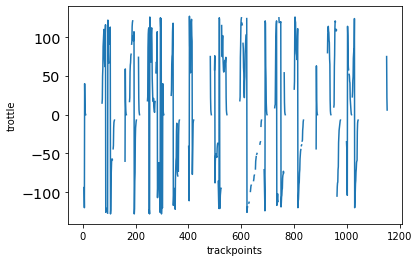

In [208]:
#overview app(=throttle) data
plt.clf()
plt.plot(circuit_seperation_df.index, circuit_seperation_df['app'])
plt.xlabel('trackpoints')
plt.ylabel('trottle')
plt.show()

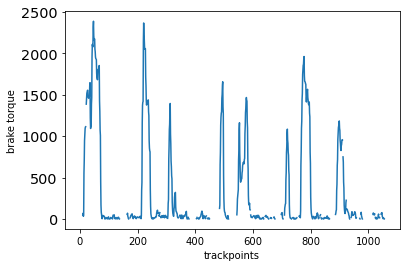

In [209]:
#overview btd(=brake torque) data
plt.clf()
plt.plot(circuit_seperation_df.index, circuit_seperation_df['btd'])
plt.xlabel('trackpoints')
plt.ylabel('brake torque')
plt.show()

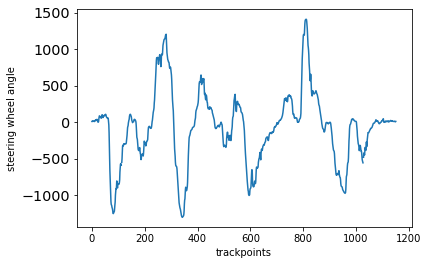

In [210]:
#overview app(=throttle) data
plt.clf()
plt.plot(circuit_seperation_df.index, circuit_seperation_df['swa'])
plt.xlabel('trackpoints')
plt.ylabel('steering wheel angle')
plt.show()

In [211]:
circuit_seperation_df['swa'].isna().sum()

50

In [212]:
circuit_seperation_df['btd'].isna().sum()

430

As we may have noticed above already the break torque data and the steering wheel angle data is incomplete. So lets fill empty values using linear interpolation.

In [213]:
circuit_seperation_df['btd']=circuit_seperation_df['btd'].interpolate()

In [214]:
circuit_seperation_df['swa']=circuit_seperation_df['swa'].interpolate()

In [215]:
circuit_seperation_df['btd'].isna().sum()

0

In [216]:
circuit_seperation_df['swa'].isna().sum()

0

Obviously there is a connection between the sterring wheel angle data and the brake torque. Entering a curve the driver has to slow down.

Lets find the extrema of the steering wheel angle to roughly estimate the center of the curves.

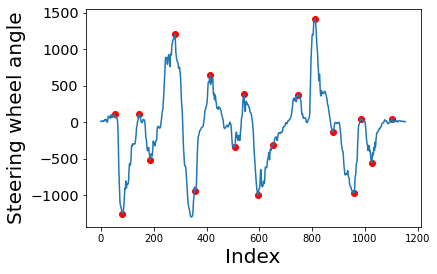

In [217]:
circuit_seperation_df['swamax'] = circuit_seperation_df[['swa']].\
iloc[find_peaks(circuit_seperation_df.swa.values,threshold=1, height= 40, distance=50)[0]]['swa']

circuit_seperation_df['swamin'] = circuit_seperation_df[['swa']].\
iloc[find_peaks(circuit_seperation_df.swa.values*-1,threshold=1, height= 40, distance=50)[0]]['swa']

# Plot results
plt.scatter(circuit_seperation_df.index, circuit_seperation_df['swamin'], c='r')
plt.scatter(circuit_seperation_df.index, circuit_seperation_df['swamax'], c='r')
plt.plot(circuit_seperation_df.index, circuit_seperation_df['swa'])
plt.xlabel('Index', fontsize=20)
plt.ylabel('Steering wheel angle', fontsize=20)
plt.show()

Now lets add the brake points. We are looking for the first brake action before each steering wheel extrema.

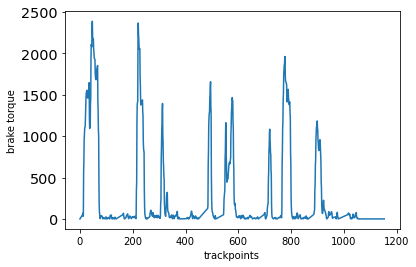

In [218]:
#overview btd(=brake torque) data
plt.clf()
plt.plot(circuit_seperation_df.index, circuit_seperation_df['btd'])
plt.xlabel('trackpoints')
plt.ylabel('brake torque')
plt.show()

The brake torque data is quite noise so lets apply a threshhold.

In [219]:
circuit_seperation_df['btd'] = circuit_seperation_df['btd'].clip(100)

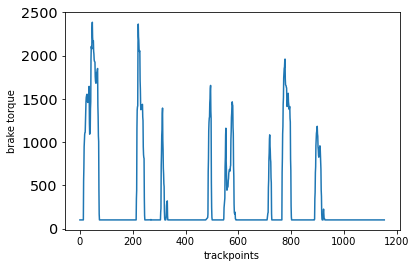

In [220]:
#overview btd(=brake torque) data
plt.clf()
plt.plot(circuit_seperation_df.index, circuit_seperation_df['btd'])
plt.xlabel('trackpoints')
plt.ylabel('brake torque')
plt.show()

That looks good. Now lets add the brake points for each steering wheel extrema.

In [221]:
circuit_seperation_df.drop('index', axis=1, inplace=True)

In [222]:
# searching for steering wheel extrema?
searchin_extr_sw = False
braking_in_curve_center = False
search_for_entry = False
brake_entry_point_indexes = []

def checkBraking(btd):
    if btd > 100.0:
        return True
    else:
        return False

for index, trackpoint in circuit_seperation_df[::-1].iterrows():

    # true if min / max
    check_swamin = not np.isnan(trackpoint["swamin"])
    check_swamax = not np.isnan(trackpoint["swamax"])
    
    if not searchin_extr_sw and (check_swamin or check_swamax):
        # no brake point found!
        searchin_extr_sw = True
        
    if searchin_extr_sw:
        # searching for the next curve center from behind
        if check_swamin:
            searchin_extr_sw = False
            braking_in_curve_center = checkBraking(trackpoint["btd"])
        if check_swamax:
            searchin_extr_sw = False
            braking_in_curve_center = checkBraking(trackpoint["btd"])
    else:
        # searching for the next braking point after the curve center in the reversed trackpoint list
        if braking_in_curve_center:
            # braking occured in the center, so we search for the next trackpoint with no brake torque,
            # to find the brake entry point of the curve  
            if trackpoint["btd"] <= 100.0:
                brake_entry_point_indexes.insert(0, index)
                searchin_extr_sw = True
                search_for_entry = False

        else:
            # braking did not occur in the center
            if search_for_entry:
                #find the brake entry point of the curve
                if trackpoint["btd"] <= 100.0:
                    brake_entry_point_indexes.insert(0, index + 1)
                    searchin_extr_sw = True
                    search_for_entry = False
            else:
                # we search for the next trackpoint with brake torque, 
                # to find the brake entry point of the curve after that
                if trackpoint["btd"] > 100.0:
                    search_for_entry = True
    
print(brake_entry_point_indexes)

[13, 268, 326, 477, 545, 710, 766, 922]


In [223]:
# based on the list of indexes of brake points create another column for the dataframe
circuit_seperation_df["brakepoints"] =\
[circuit_seperation_df.index.values[i] in brake_entry_point_indexes for i in circuit_seperation_df.index.values]

In [224]:
#copy the true brake points to a new dataframe visualize them
brakepoint_df = circuit_seperation_df[circuit_seperation_df["brakepoints"] == True].copy()

In [225]:
brakepoint_df

,circuitname,racenumber,lapCounter,ts,lat,lon,swa,btd,app,userProfileName,swamax,swamin,brakepoints
13,Circuito del Jarama,1,1,1302,40.613959,-3.582807,28.0,100.0,NaN,Guest,NaN,NaN,True
268,Circuito del Jarama,1,1,26802,40.615434,-3.584520,1006.0,101.0,21.0,Guest,NaN,NaN,True
326,Circuito del Jarama,1,1,32602,40.614707,-3.585311,-889.0,116.0,NaN,Guest,NaN,NaN,True
477,Circuito del Jarama,1,1,47701,40.617523,-3.588238,-46.0,101.6,NaN,Guest,NaN,NaN,True
545,Circuito del Jarama,1,1,54502,40.619042,-3.590630,201.0,112.0,2.0,Guest,NaN,NaN,True
710,Circuito del Jarama,1,1,71002,40.619107,-3.588952,21.0,131.0,NaN,Guest,NaN,NaN,True
766,Circuito del Jarama,1,1,76601,40.618014,-3.586932,65.0,647.0,1.0,Guest,NaN,NaN,True
922,Circuito del Jarama,1,1,92201,40.619621,-3.588219,-635.0,196.0,NaN,Guest,NaN,NaN,True


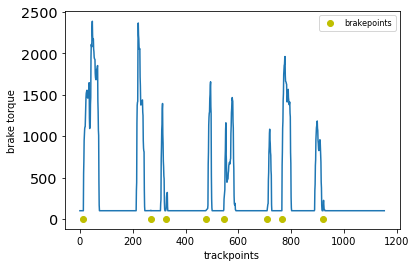

In [226]:
#overview btd(=brake torque) data
plt.clf()
plt.plot(circuit_seperation_df.index, circuit_seperation_df['btd'])
brakepoints = plt.scatter(brakepoint_df.index, brakepoint_df['brakepoints'], c='y')
plt.xlabel('trackpoints')
plt.ylabel('brake torque')
plt.legend([brakepoints],
           ['brakepoints'],
           scatterpoints=1,
           loc='upper right',
           ncol=1,
           fontsize=8)
plt.show()

In [227]:
#swap the boolean with the steering wheel value(swa) to show it together with the steering wheel angle on a plot
brakepoint_df["brakepoints"] = circuit_seperation_df.loc[circuit_seperation_df.index[list(brakepoint_df.index.values)]]["swa"]

In [228]:
brakepoint_df

,circuitname,racenumber,lapCounter,ts,lat,lon,swa,btd,app,userProfileName,swamax,swamin,brakepoints
13,Circuito del Jarama,1,1,1302,40.613959,-3.582807,28.0,100.0,NaN,Guest,NaN,NaN,28.0
268,Circuito del Jarama,1,1,26802,40.615434,-3.584520,1006.0,101.0,21.0,Guest,NaN,NaN,1006.0
326,Circuito del Jarama,1,1,32602,40.614707,-3.585311,-889.0,116.0,NaN,Guest,NaN,NaN,-889.0
477,Circuito del Jarama,1,1,47701,40.617523,-3.588238,-46.0,101.6,NaN,Guest,NaN,NaN,-46.0
545,Circuito del Jarama,1,1,54502,40.619042,-3.590630,201.0,112.0,2.0,Guest,NaN,NaN,201.0
710,Circuito del Jarama,1,1,71002,40.619107,-3.588952,21.0,131.0,NaN,Guest,NaN,NaN,21.0
766,Circuito del Jarama,1,1,76601,40.618014,-3.586932,65.0,647.0,1.0,Guest,NaN,NaN,65.0
922,Circuito del Jarama,1,1,92201,40.619621,-3.588219,-635.0,196.0,NaN,Guest,NaN,NaN,-635.0


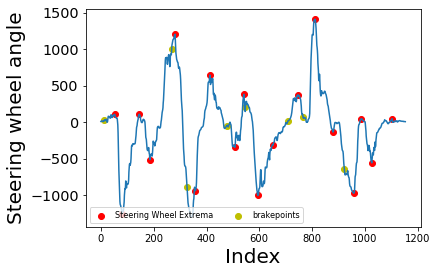

In [262]:
# Plot results: yellow dots are breakpoints
mins = plt.scatter(circuit_seperation_df.index, circuit_seperation_df['swamin'], c='r')
maxs = plt.scatter(circuit_seperation_df.index, circuit_seperation_df['swamax'], c='r')
brakepoints = plt.scatter(brakepoint_df.index, brakepoint_df['brakepoints'], c='y')
plt.plot(circuit_seperation_df.index, circuit_seperation_df['swa'])
plt.xlabel('Index', fontsize=20)
plt.ylabel('Steering wheel angle', fontsize=20)

plt.legend((mins, brakepoints),
           ('Steering Wheel Extrema', 'brakepoints'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)

plt.show()

In this example in 8 out of 17 the driver braked before a corner.

We now can identify curve centers and their brakepoints.

Remaining are:
- straight parts
- Curve entrances
- Curve exit
- Throttle 100% after curve exit

Curve entrances and exits we simply define using the steering wheel angle. Everything above 15° belongs to a curve.

The remaining parts will be defined as straight parts.

The throttle data is given as the column name "app".


In [244]:
#introduce new column "curve"
circuit_seperation_df['curve'] = circuit_seperation_df.swa.apply(lambda x: False if 15.0 >= x/10 >= -15.0 else True)

In [246]:
circuit_seperation_df[circuit_seperation_df["curve"]==True].shape[0]

682

Roughly 862 Trackpoints out of 1200 belong to a curve.

The only information left now is when the throttle is pushed to 100% after each curve. 

The throttle diagram above shows that the data is a little bit noisy so we will define any value above 
100 as full throttle.

In [259]:
# searching for steering wheel extrema?
searchin_extr_sw = False
full_throttle_points_indexes = []

for index, trackpoint in circuit_seperation_df.iterrows():

        # true if min / max
    check_swamin = not np.isnan(trackpoint["swamin"])
    check_swamax = not np.isnan(trackpoint["swamax"])
    
    if not searchin_extr_sw and (check_swamin or check_swamax):
        # no full throttle point found!
        searchin_extr_sw = True
        
    if searchin_extr_sw:
        # searching for the next curve center from behind
        if check_swamin:
            searchin_extr_sw = False
        if check_swamax:
            searchin_extr_sw = False
    else:
        # searching for the next full throttle point after the curve center in the trackpoint list
        if trackpoint["app"] >= 100.0:
            full_throttle_points_indexes.insert(0, index - 1)
            searchin_extr_sw = True
    
print(full_throttle_points_indexes)

[1028, 1002, 958, 927, 812, 748, 690, 598, 516, 403, 281, 186, 84, 78]


In [260]:
# based on the list of indexes of full throttle points after curves create another column for the dataframe
circuit_seperation_df["full_throttle"] =\
[circuit_seperation_df.index.values[i] in full_throttle_points_indexes for i in circuit_seperation_df.index.values]

In [261]:
circuit_seperation_df

,circuitname,racenumber,lapCounter,ts,lat,lon,swa,btd,app,userProfileName,swamax,swamin,brakepoints,curve,full_throttle
0,Circuito del Jarama,1,1,0,40.614612,-3.583085,9.00,100.0,-6.0,Guest,NaN,NaN,False,False,False
1,Circuito del Jarama,1,1,101,40.614612,-3.583085,15.00,100.0,NaN,Guest,NaN,NaN,False,False,False
2,Circuito del Jarama,1,1,201,40.614596,-3.583078,16.00,100.0,NaN,Guest,NaN,NaN,False,False,False
3,Circuito del Jarama,1,1,304,40.614487,-3.583032,15.75,100.0,NaN,Guest,NaN,NaN,False,False,False
4,Circuito del Jarama,1,1,402,40.614433,-3.583009,15.50,100.0,NaN,Guest,NaN,NaN,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,Circuito del Jarama,1,1,114901,40.614833,-3.583167,9.00,100.0,NaN,Guest,NaN,NaN,False,False,False
1150,Circuito del Jarama,1,1,115002,40.614779,-3.583144,10.00,100.0,NaN,Guest,NaN,NaN,False,False,False
1151,Circuito del Jarama,1,1,115101,40.614731,-3.583124,8.50,100.0,75.0,Guest,NaN,NaN,False,False,False
1152,Circuito del Jarama,1,1,115202,40.614677,-3.583102,7.00,100.0,22.0,Guest,NaN,NaN,False,False,False


In [268]:
#copy the true brake points to a new dataframe visualize them
full_throttle_df = circuit_seperation_df[circuit_seperation_df["full_throttle"] == True].copy()

In [271]:
#swap the boolean with the steering wheel value(swa) to show it together with the steering wheel angle on a plot
full_throttle_df["full_throttle"] = circuit_seperation_df.loc[circuit_seperation_df.index[list(full_throttle_df.index.values)]]["swa"]

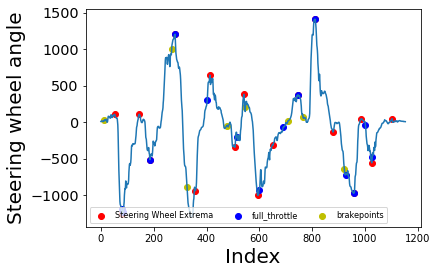

In [272]:
# Plot results: blue dots are full_throttle points
mins = plt.scatter(circuit_seperation_df.index, circuit_seperation_df['swamin'], c='r')
maxs = plt.scatter(circuit_seperation_df.index, circuit_seperation_df['swamax'], c='r')
brakepoints = plt.scatter(brakepoint_df.index, brakepoint_df['brakepoints'], c='y')
full_throttle = plt.scatter(full_throttle_df.index, full_throttle_df['full_throttle'], c='b')
plt.plot(circuit_seperation_df.index, circuit_seperation_df['swa'])
plt.xlabel('Index', fontsize=20)
plt.ylabel('Steering wheel angle', fontsize=20)

plt.legend((mins, full_throttle,brakepoints),
           ('Steering Wheel Extrema','full_throttle', 'brakepoints'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)

plt.show()

One clearly can see that most of the times in the center of the curve the driver fully starts to accelerate again.

We have all the data we need now to form some nice track plots of

- straight parts
- Curve entrances
- Center of curves
- Curve exit
- Braking points
- Throttle 100% after curve exit